In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
df = pd.read_csv('Mall_Customers.csv')
df = df.rename(columns={'Genre': 'Gender', 'Annual_Income_(k$)': 'AnnualIncome', 'Spending_Score': 'SpendingScore'})
df.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [57]:
gender_numeric = {'Female': 1, 'Male': 0}
df.Gender = df['Gender'].map(gender_numeric)
df.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [64]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
customers_train_all_vars = df_train[['Gender', 'Age', 'AnnualIncome', 'SpendingScore']]
model_all = smf.ols(formula='SpendingScore ~ Gender + Age + AnnualIncome', data=customers_train_all_vars).fit()
print(model_all.summary())


                            OLS Regression Results                            
Dep. Variable:          SpendingScore   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.763
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           0.000917
Time:                        21:03:53   Log-Likelihood:                -741.98
No. Observations:                 160   AIC:                             1492.
Df Residuals:                     156   BIC:                             1504.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       70.7065      8.032      8.803   

From the above OLS run there doesn't seem to exist a linear relation between the variables the variables of Gender, Age and AnnualIncome factored together vs SpendingScore. We see gender has the highest p-value meaning its the least significant. Out of curiousity we can remove that variable and run the model again to see if things improve.

In [65]:
customer_train_most_significant = df_train[['SpendingScore', 'AnnualIncome', 'Age']]
model_signficant = smf.ols(formula='SpendingScore ~ AnnualIncome + Age', data=customer_train_most_significant).fit()
print(model_signficant.summary())


                            OLS Regression Results                            
Dep. Variable:          SpendingScore   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     8.652
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           0.000273
Time:                        21:04:15   Log-Likelihood:                -742.03
No. Observations:                 160   AIC:                             1490.
Df Residuals:                     157   BIC:                             1499.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       71.5326      7.509      9.526   

Seemingly the R2 value got worse. Linear Regression will not be the right choice to gain insights into this dataset. To make this even more clear we can test both models on the test_data set to see what the error is.  

In [66]:
customers_test_all_vars  = df_test[['Gender', 'Age', 'AnnualIncome', 'SpendingScore']]
customer_test_most_significant  = df_test[['SpendingScore', 'AnnualIncome', 'Age']]

results_all = model_all.predict(customers_test_all_vars)
results_significant = model_signficant.predict(customer_test_most_significant)

mse_all = mean_squared_error(customers_test_all_vars['SpendingScore'], results_all)
mse_significant = mean_squared_error(customer_test_most_significant['SpendingScore'], results_significant)

print("Mean Squared Error (All Variables):", mse_all)
print("Mean Squared Error (Most Significant Variables):", mse_significant)

Mean Squared Error (All Variables): 480.6731417072484
Mean Squared Error (Most Significant Variables): 483.55682175408367


The above result should make it obvious linear regression won't work.

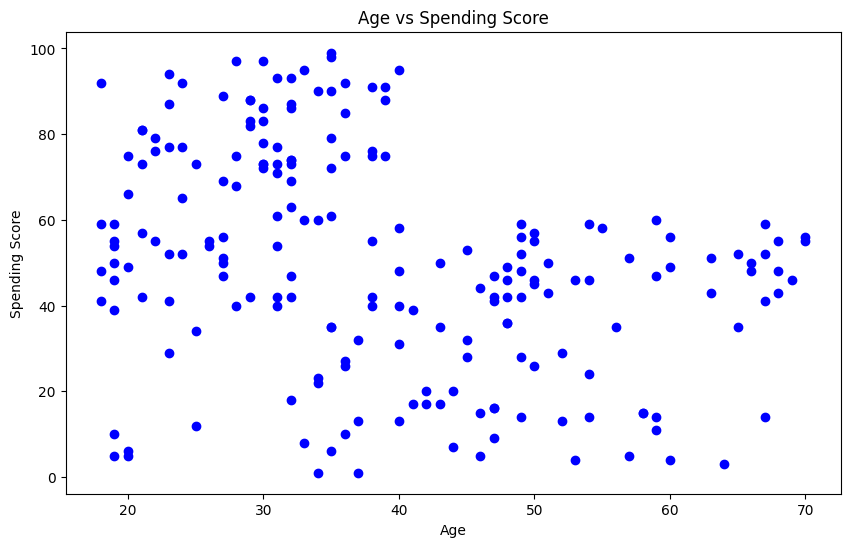

In [61]:
df_age_vs_spending = df[['Age', 'SpendingScore']]

plt.figure(figsize=(10, 6))
plt.title('Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.scatter(x='Age', y='SpendingScore', data=df_age_vs_spending, color='blue')
plt.show()

Focusing on just the variables of Age and Spending Score we can see that there are different sections of the graph with may datapoints grouped together. With this sort of pattern some sort of clustering algorithm can be beneficial to gain insight on what is happening.

In [54]:
X1 = df_age_vs_spending.iloc[:,:].values
inertias = []

for n in range(1, 15):
    algorithm = (KMeans(n_clusters = 1 ,init='k-means++', n_init = 10 ,max_iter=300,
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertias.append(algorithm.inertia_)






/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:1408: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


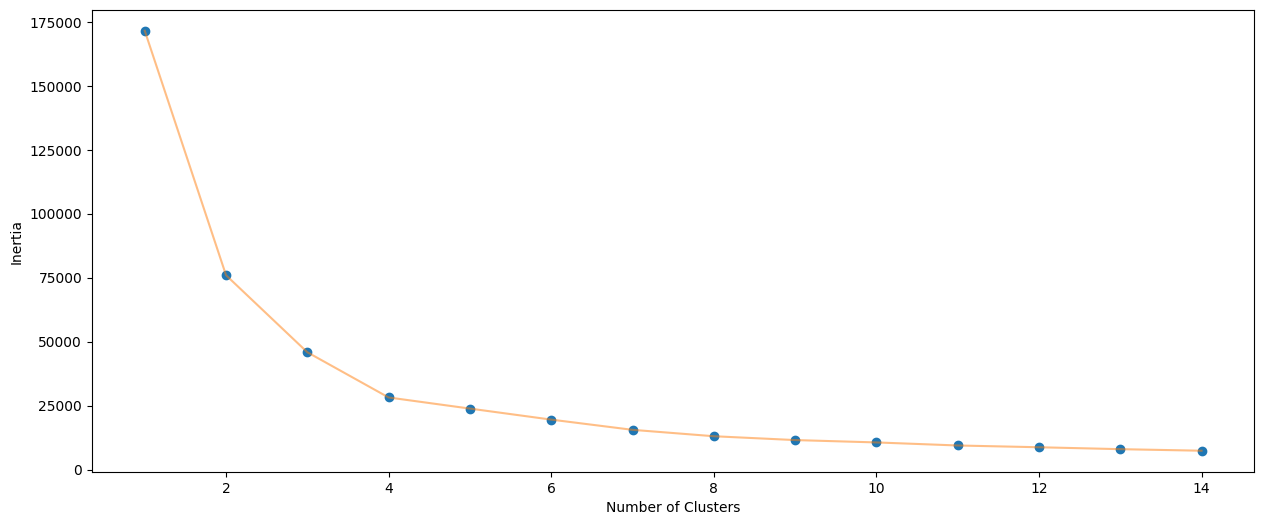

In [55]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 15) , inertias , 'o')
plt.plot(np.arange(1 , 15) , inertias , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Inertia for k means clustering measures how well the data points are grouped. It's measured by first squaring the distance between each data point and its centroid, then adding up all the squared distances arounded each cluster. We typically want a model that has low inertia and low amount of clusters. looking at the graph 5 clusters seems to be the ideal spot where the inertia is relatively low and the amount of clusters is still small.

In [67]:
kmeans_model = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=111, algorithm='elkan')
kmeans_model.fit(X1)
labels = kmeans_model.labels_
centroids = kmeans_model.cluster_centers_

In [68]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

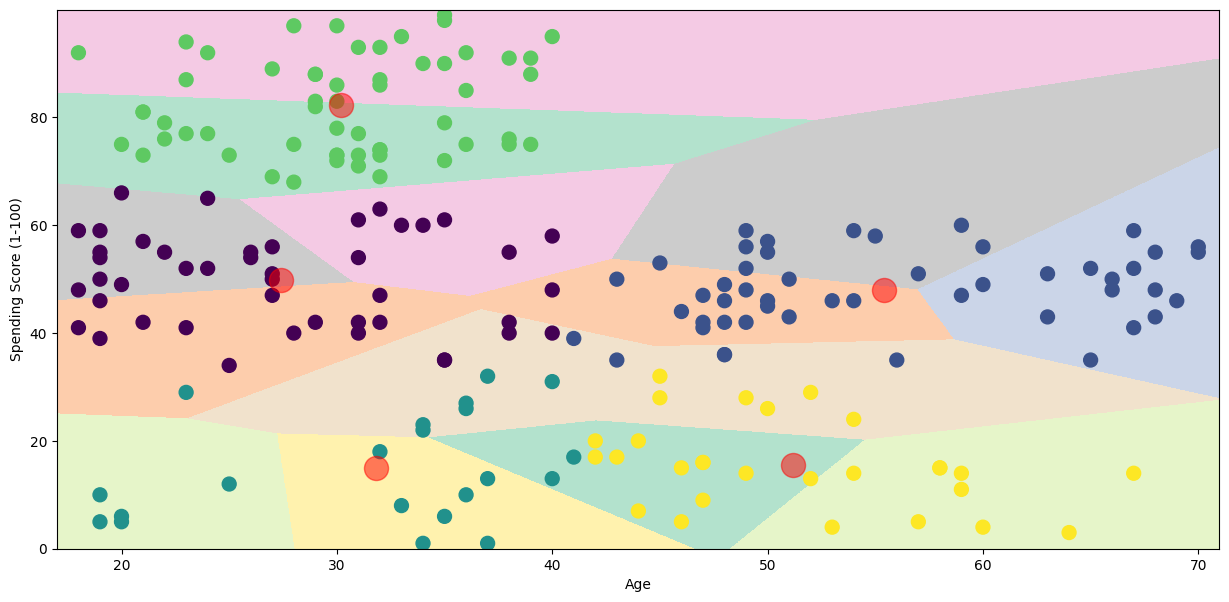

In [72]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age', y = 'SpendingScore', data = df_age_vs_spending, c = labels, s = 100)
plt.scatter(x = centroids[: , 0] , y =  centroids[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

Using linear regression on all the data together proved to be unsuccessful. However now that we have data in different clusters we can see that linear relationships do exist between dataopoints in different groups. Now we can run linear models on different sections seperately and likely have better luck for having a seperate model for different ranges a customer may fall into.